# LEGO PROJECT
Learning how to use Machine Learning <br> <br>
This is my first attempt at machine learning. I'm using the relatively clean 'final cleaned df.csv' data set that I scraped from ebay. As I worked through some basic ML algorothms I noticed my data needed more transformation, cleaning and filtering, which I did. 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from datetime import datetime
%matplotlib inline

### Data Cleanup

In [2]:
df = pd.read_csv('final_cleaned_df.csv')
df.drop(["Unnamed: 0", 'year_released', 'age_range', 'packaging'], axis=1, inplace=True)

# replace Nan in minifig columns with zero
df['minifigs_total'] = df['minifigs_total'].fillna(0)
df['minifigs_unique'] = df['minifigs_unique'].fillna(0)

# change date column types
df['launch_date'] = pd.to_datetime(df['launch_date'])
df['retirement_date'] = pd.to_datetime(df['retirement_date'])

# create time since retirement, should be easier to use than retirement date for ML
current_date = pd.to_datetime('now')
df['time_since_retirement'] =  current_date - df['retirement_date']
df['time_since_retirement'] = df['time_since_retirement']//np.timedelta64(1, 'M')

# set index to set_num
df.set_index('set_num', inplace=True)

df.head()

,set_name,theme_group,theme,subtheme,pieces,designer,msrp,availability,rating,launch_date,retirement_date,minifigs_total,minifigs_unique,pct_appreciation,time_since_retirement
set_num,,,,,,,,,,,,,,,
60009,Helicopter Arrest,Modern day,City,Police,352.0,Henrik Andersen,49.99,Retail - limited,3.8,2013-01-01,NaT,5.0,0.0,56.50,NaN
60012,Coast Guard 4x4 & Diving Boat,Modern day,City,Coast Guard,128.0,NaN,19.99,Retail,3.8,2013-06-01,2015-07-31,2.0,2.0,NaN,79.0
75975,Watchpoint: Gibraltar,Licensed,Overwatch,NaN,730.0,Mark Stafford,89.99,Retail,3.9,2019-01-01,2020-07-31,4.0,3.0,-6.80,19.0
10155,Maersk Line Container Ship,Model making,Creator Expert,Maersk,990.0,NaN,119.99,LEGO exclusive,4.1,2010-08-01,2011-07-31,0.0,0.0,205.25,127.0
10210,Imperial Flagship,Model making,Creator Expert,Miscellaneous,1664.0,Raphael Pretesacque,179.99,Retail - limited,4.6,2010-01-01,2011-12-31,9.0,6.0,630.00,122.0


Remove features (columns) that aren't important to the model

In [3]:
df.drop(['set_name', 'launch_date',], axis=1, inplace=True)

Swap last two columns to get pct_appreciation (our label) to the end

In [4]:
titles = list(df.columns)
titles[10], titles[11] = titles[11], titles[10]
df = df[titles]
df.shape

(1862, 13)

How many unique values in each column?

In [5]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
6,availability,5
0,theme_group,14
7,rating,20
11,minifigs_unique,21
9,minifigs_total,24
12,time_since_retirement,36
8,retirement_date,37
4,designer,66
5,msrp,79
1,theme,82


In [6]:
num_nulls = pd.DataFrame(df.isnull().sum())
num_nulls

,0
theme_group,0
theme,0
subtheme,434
pieces,140
designer,1182
msrp,1
availability,266
rating,293
retirement_date,365
minifigs_total,0


In [7]:
# If there is no msrp can't calculate an appreciation, delete these rows
df.drop(df[df['msrp'].isnull()].index, inplace=True)

In [8]:
# Sets with nulls in pieces cloumn are usually non-builder sets, i.e. plush, watches, hats
# DELETE THEM!
df.drop(df[df['pieces'].isnull()].index, inplace=True)

In [9]:
num_nulls = pd.DataFrame(df.isnull().sum())
num_nulls

,0
theme_group,0
theme,0
subtheme,433
pieces,0
designer,1041
msrp,0
availability,136
rating,152
retirement_date,224
minifigs_total,0


I only want to create a model on sets that have retired, doesn't make sense to analyze sets that are still officially for sale in normal retail channels. I will split the dataset into <br> 1) sets that have retired <br>2) sets that haven't retired

In [10]:
df_retired = df[df['retirement_date'].notnull()].copy()
nan_count = df_retired['retirement_date'].isna().sum()
print(nan_count)
df_not_retired = df[df['retirement_date'].isnull()]
df_not_retired.shape
print(df_not_retired['retirement_date'].isnull().sum())

0
224


<AxesSubplot:>

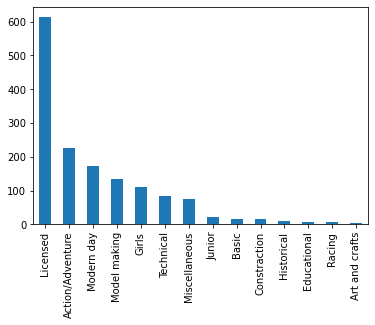

In [11]:
df_retired['theme_group'].value_counts().plot.bar()


<AxesSubplot:>

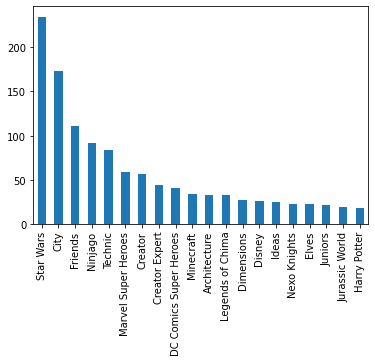

In [12]:
df_retired['theme'].value_counts().head(20).plot.bar()

<AxesSubplot:>

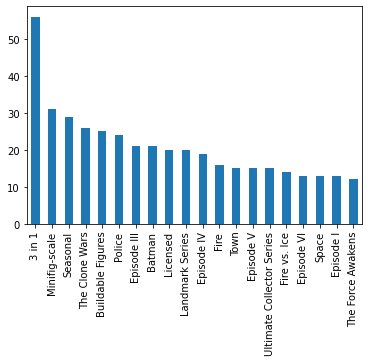

In [13]:
df_retired['subtheme'].value_counts().head(20).plot.bar()

<AxesSubplot:>

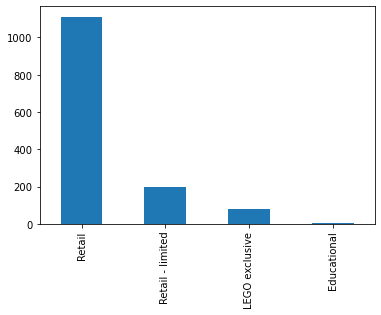

In [14]:
df_retired['availability'].value_counts().plot.bar()


<AxesSubplot:>

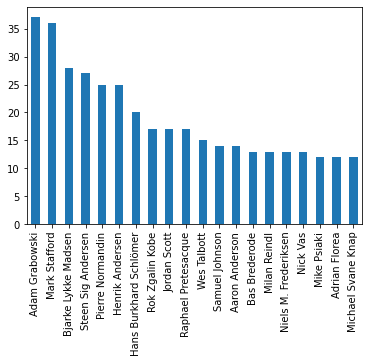

In [15]:
df_retired['designer'].value_counts().head(20).plot.bar()

In [16]:
df_retired.isna().sum()

theme_group                0
theme                      0
subtheme                 363
pieces                     0
designer                 909
msrp                       0
availability             103
rating                    95
retirement_date            0
minifigs_total             0
pct_appreciation          76
minifigs_unique            0
time_since_retirement      0
dtype: int64

In [17]:
# there are some nan values in pct_appreciation, lets assume for now that these sets are so
# unpopular that they don't sell on the secondary market and we can assign them an appreciatoin of ZERO 
df_retired['pct_appreciation'] = df_retired['pct_appreciation'].fillna(0)

array([[<AxesSubplot:title={'center':'pct_appreciation'}>]], dtype=object)

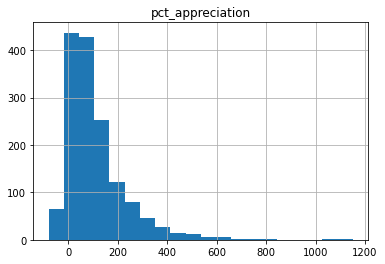

In [18]:
df_retired.hist(column='pct_appreciation', bins=20)

Text(0.5, 1.0, 'Percent Appreciation Histogram w/ Cumulative')

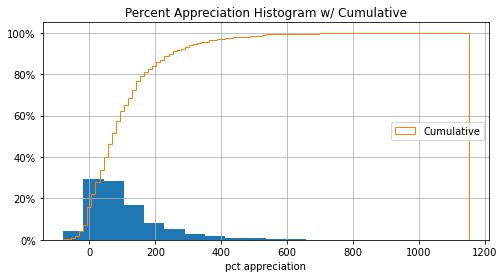

In [47]:
fig, ax = plt.subplots(figsize=(8,4))

ax.hist(df_retired['pct_appreciation'], bins=20, 
        weights=np.ones(len(df_retired['pct_appreciation'])) / len(df_retired['pct_appreciation']))
ax.set_xlabel('pct appreciation')
ax.yaxis.set_major_formatter(PercentFormatter(1))

n, bines, patches = ax.hist(df_retired['pct_appreciation'], label='Cumulative',
        bins=100, density=True, histtype='step', cumulative=True)

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Percent Appreciation Histogram w/ Cumulative')

<AxesSubplot:xlabel='pieces', ylabel='msrp'>

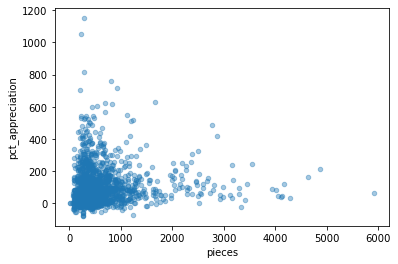

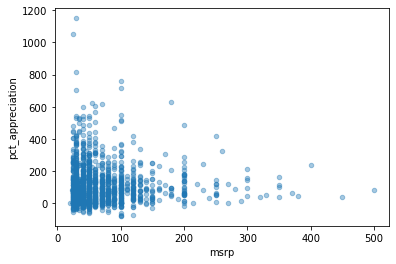

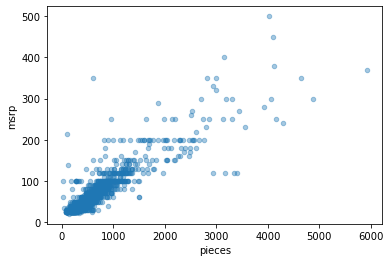

In [48]:
df_retired.plot.scatter(x="pieces", y="pct_appreciation", alpha=0.4)
df_retired.plot.scatter(x="msrp", y="pct_appreciation", alpha=0.4)
df_retired.plot.scatter(x="pieces", y="msrp", alpha=0.4)

# Linear Regression

Test with a simple relationship - # pieces vs msrp

In [49]:
lr = LinearRegression()

In [50]:
lr.fit(df_retired[['pieces']], df_retired['msrp'])

LinearRegression()

In [51]:
fit_df = pd.DataFrame({'pieces': range(0, 6000)})
fit_df['predicted_msrp'] = lr.predict(fit_df)
fit_df

,pieces,predicted_msrp
0,0,16.784916
1,1,16.863686
2,2,16.942457
3,3,17.021227
4,4,17.099997
...,...,...
5995,5995,489.013022
5996,5996,489.091792
5997,5997,489.170563
5998,5998,489.249333


<AxesSubplot:xlabel='pieces', ylabel='msrp'>

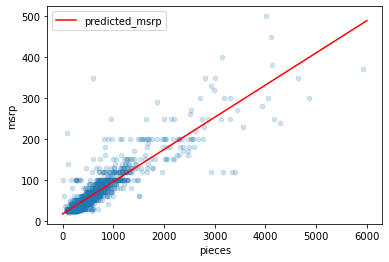

In [52]:
ax = fit_df.plot.line(x='pieces', y='predicted_msrp', color='red')
df_retired.plot.scatter(x='pieces', y='msrp', ax=ax, alpha=0.2)

In [53]:
lr.score(df_retired[['pieces']], df_retired['msrp'])

0.7924469748433091

But this is using all the data, we should split it into train (fit) and test subsets
to make sure the model isn't just memorizing all the data. <br>
This will be a better test if the model is actually learning anything.

In [54]:
train_df, test_df = train_test_split(df_retired, test_size=0.15)
lr = LinearRegression()
lr.fit(train_df[['pieces']], train_df['msrp']) # train the model on the train df
lr.score(test_df[['pieces']], test_df['msrp']) # score the model on the test df

# if you run this multiple times you will see the score value changing
# this is because of the variance in the data when you split it

0.7634611230016107

In [55]:
# we can see this variance with the code below
train_df['msrp'].var(), test_df['msrp'].var()

(2995.8272307468546, 2003.7487301587282)

## Cross Validation
Use different chunks of data for train/test (folds) and see how the model scores change

In [56]:
scores = cross_val_score(lr, train_df[['pieces']], train_df['msrp'], cv=10)
scores.mean()
# should probably use the test dataframe to score the models in production
# OR are you supposed to use the entire dataset?

0.7820663338987672

In [57]:
# Let's add some more features
train_df, test_df = train_test_split(df_retired, test_size=0.15)
lr = LinearRegression()
lr.fit(train_df[['pieces', 'minifigs_total']], train_df['msrp']) # train the model on the train df
lr.score(test_df[['pieces', 'minifigs_total']], test_df['msrp']) # score the model on the test df
scores2 = cross_val_score(lr, test_df[['pieces', 'minifigs_total']], test_df['msrp'], cv=10)
scores2.mean()

# interesting the model score went down
# could be because I used test df for this one and train df for the last one.

0.8239029214554947

## More exploration

Looks like a non-linear relationship, bit of a bump in the middle. But regression needs a straight line. Investigate polynomial regression.

<AxesSubplot:title={'center':'pct_appreciation'}, xlabel='retirement_date'>

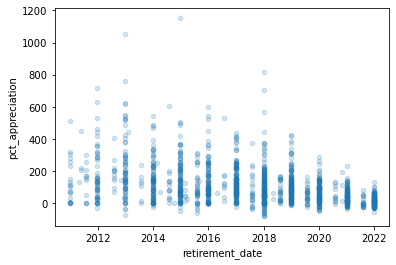

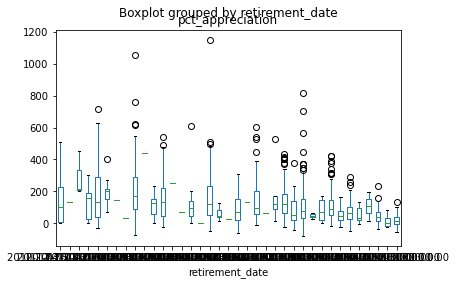

In [58]:
df_retired.plot.scatter(x="retirement_date", y="pct_appreciation", alpha=0.2)
df_retired.boxplot(by='retirement_date', column=['pct_appreciation'], grid=False)

Do the # of minifigs correlate to better appreciation?

<AxesSubplot:xlabel='minifigs_unique', ylabel='pct_appreciation'>

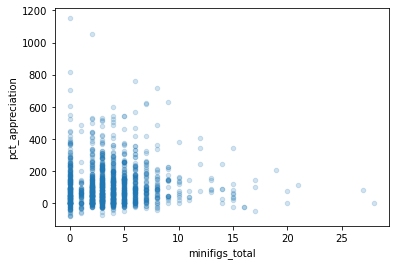

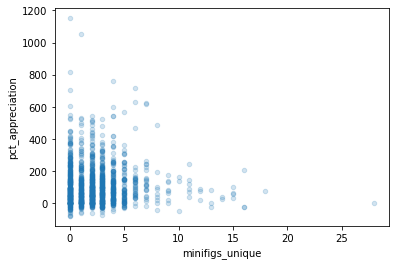

In [59]:
df_retired.plot.scatter(x="minifigs_total", y="pct_appreciation", alpha=0.2)
df_retired.plot.scatter(x="minifigs_unique", y="pct_appreciation", alpha=0.2)

## Linear Regression on minifigs vs appreciation

In [65]:
train_df, test_df = train_test_split(df_retired, test_size=0.2)
lr = LinearRegression()
lr.fit(train_df[['minifigs_total']], train_df['pct_appreciation'])
lr.score(test_df[['minifigs_total']], test_df['pct_appreciation'])

# negative R2, OK, this is worse than taking the mean.

-0.0010926303539808835

In [68]:
# Looks like there is no correlation
# Let's try permutation testing
# returns a tuple of score, garbage scores, pvalue
score, garbage_scores, pvalue = permutation_test_score(lr, test_df[['minifigs_total']], test_df['pct_appreciation'])
score, pvalue

(-0.014072120640581453, 0.297029702970297)

<AxesSubplot:>

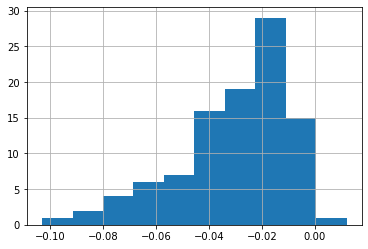

In [69]:
pd.Series(garbage_scores).hist()

In [70]:
pvalue
# pvalue is high indicating there is a good chance you could recreate the model with random label changes
# not good
# but it makes sense, when we added the minifig features to the model above the r2 score went down!

0.297029702970297

# Sklearn Pipeline

Model 1 - Linear Regression Using Multiple Features

<AxesSubplot:xlabel='time_since_retirement', ylabel='pct_appreciation'>

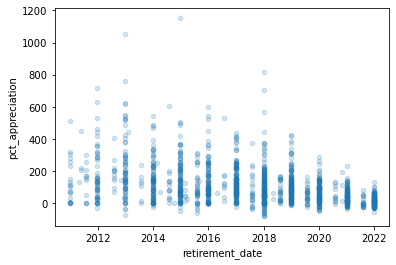

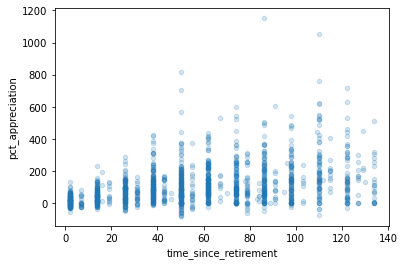

In [71]:
df_retired.plot.scatter(x="retirement_date", y="pct_appreciation", alpha=0.2)
df_retired.plot.scatter(x="time_since_retirement", y="pct_appreciation", alpha=0.2)



In [130]:
train_df, test_df = train_test_split(df_retired)
m1 = LinearRegression()
m1.fit(train_df[['time_since_retirement']], train_df['pct_appreciation'])
print(m1.score(test_df[['time_since_retirement']], test_df['pct_appreciation']))
train_df['pct_appreciation'].var(), test_df['pct_appreciation'].var() # check variance between data sets

# Every time this model is run the score is different
# This is mostly due to the variance from the mean in the train vs test dataframes

0.18146357915125166


(14517.297890293263, 16047.189942203853)

Cross Validation <br>
Take different chunks (folds) of data to be train and test, do this cv times and get a score for each iteration <br> **** NEVER USE YOUR TEST DATA FOR TUNING ****

In [140]:
train_df, test_df = train_test_split(df_retired)
m1 = LinearRegression()
# m1.fit(train_df[['time_since_retirement']], train_df['pct_appreciation'])
scores1 = cross_val_score(m1, train_df[['time_since_retirement']], train_df['pct_appreciation'], cv=3)
scores1.mean()

0.1385393059821559

Model 2 Polynomial Regression

In [74]:
# This is showing what the fit transform method does
# create an instance of polynomialfeautures class
poly = PolynomialFeatures(degree=2, include_bias=False) # bias=False -> no to the zero power

# use fit transform method and set to date variable
data = poly.fit_transform(train_df[['time_since_retirement']])

# create a dataframe from the array that fit transform returns
pd.DataFrame(data, columns=poly.get_feature_names_out(["time_since_retirement"]))

,time_since_retirement,time_since_retirement^2
0,38.0,1444.0
1,2.0,4.0
2,62.0,3844.0
3,38.0,1444.0
4,62.0,3844.0
...,...,...
1117,62.0,3844.0
1118,26.0,676.0
1119,50.0,2500.0
1120,74.0,5476.0


In [ ]:
# A pipeline will take a tranformer and an estimator
m2 = Pipeline([
            ("poly", PolynomialFeatures(degree=2, include_bias=False)), # Transformer
            ("lr", LinearRegression()) # estimator
])
m2

In [ ]:
# m2 is now our model and we can do all things we did with the previous models
m2.fit(train_df[['time_since_retirement']], train_df['pct_appreciation'])
scores2 = cross_val_score(m2, train_df[['time_since_retirement']], train_df['pct_appreciation'], cv=10)
scores2.mean()

Model 3 - Linear Regression with OneHotEncoder

In [ ]:
# deomonstrate how onehot works

# create a onehotencoder object
oh = OneHotEncoder()
data = oh.fit_transform(train_df[['theme_group']])
pd.DataFrame(data.toarray(), columns=oh.get_feature_names_out())

In [ ]:
# do the onehot as above, but incorporate into a pipepline
m3 = Pipeline([
            ("onehot", OneHotEncoder()),
            ("lr", LinearRegression())
])
scores3 = cross_val_score(m3, train_df[['theme_group']], train_df['pct_appreciation'], cv=10)
scores3.mean()

In [ ]:
m3_1 = Pipeline([
            ("onehot4", OneHotEncoder(handle_unknown='ignore')), # added handle arg because was getting ValueError: Found unknown categories
            ("lr4", LinearRegression())
])
scores3_1 = cross_val_score(m3_1, train_df[['theme']], train_df['pct_appreciation'], cv=10)
scores3_1.mean()

# unknown categories error happens when the test data sees a value that wasnt in the train data.
# would stratify help this?

In [ ]:
m3_2 = Pipeline([
            ("onehot4", OneHotEncoder(handle_unknown='ignore')),
            ("lr5", LinearRegression())
])
scores3_2 = cross_val_score(m3_2, train_df[['subtheme']], train_df['pct_appreciation'], cv=10)
scores3_2.mean()

Model 4 - Combination of models using Pipeline and Column Transformer

In [ ]:
# Using theme_group

m4 = Pipeline([
    ('both', make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['theme_group']),
                                    (PolynomialFeatures(degree=2, include_bias=False), ['time_since_retirement']))),
                                    ('lr', LinearRegression())
])
scores4 = cross_val_score(m4, train_df[['theme_group', 'time_since_retirement']], train_df['pct_appreciation'], cv=10)
scores4.mean()

In [ ]:
# Using theme

m5 = Pipeline([
    ('both', make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['theme']),
                                    (PolynomialFeatures(degree=2, include_bias=False), ['time_since_retirement']))),
                                    ('lr', LinearRegression())
])
score5 = cross_val_score(m5, train_df[['theme', 'time_since_retirement']], train_df['pct_appreciation'], cv=10)
score5.mean()

In [ ]:
# Using subtheme

m6 = Pipeline([
    ('both', make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['subtheme']),
                                    (PolynomialFeatures(degree=2, include_bias=False), ['time_since_retirement']))),
                                    ('lr', LinearRegression())
])
score6 = cross_val_score(m6, train_df[['subtheme', 'time_since_retirement']], train_df['pct_appreciation'], cv=10)
score6.mean()

In [ ]:
# using all the theme features

m7 = Pipeline([
    ('both', make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['theme_group', 'theme', 'subtheme']),
                                    (PolynomialFeatures(degree=2, include_bias=False), ['time_since_retirement']))),
                                    ('lr', LinearRegression())
])
score7 = cross_val_score(m7, train_df[['theme', 'theme_group', 'subtheme', 'time_since_retirement']], train_df['pct_appreciation'], cv=10)
score7.mean()

# our acuracy is going backwards

In [ ]:
# using just theme_group and theme, not subtheme

m8 = Pipeline([
    ('both', make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['theme_group', 'theme']),
                                    (PolynomialFeatures(degree=2, include_bias=False), ['time_since_retirement']))),
                                    ('lr', LinearRegression())
])
score8 = cross_val_score(m8, train_df[['theme', 'theme_group', 'time_since_retirement']], train_df['pct_appreciation'], cv=10)
score8.mean()

# best model yet @ 22%

In [ ]:
train_df